In [24]:
import torch
import torch.nn as nn
import torch.tensor as T

import numpy as np
import tensorflow as tf
from torch.autograd import Variable as V

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm.auto import tqdm

plt.style.use('classic')
matplotlib.rcParams['animation.html'] = 'html5'

In [2]:
torch.cuda.is_available()

True

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

inp_size = X_train.shape[1] * X_train.shape[2]
X = X_train.reshape(-1, inp_size) / 255.
y = tf.keras.utils.to_categorical(y_train)

X.shape, y.shape

((60000, 784), (60000, 10))

In [4]:
class FFN(nn.Module):
    def __init__(self, layer_defs):
        super(FFN, self).__init__()

        layers = []
        for l in range(1, len(layer_defs)):
            inp, activation = layer_defs[l]
            out, _ = layer_defs[l-1]

            layers.append(nn.Linear(out, inp))
            layers.append(activation())

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [5]:
def sample_G(sample_size=1):
    noise = torch.rand(sample_size, latent_size).cuda()
    return G(noise).cuda()

In [6]:
def sample_Data(sample_size=1):
    idx = np.random.randint(len(X), size=sample_size)
    return T(X[idx, :]).float().cuda()

In [30]:
def plot_sample_images(sampler, num_images):
    g_imgs = sampler(num_images).reshape(num_images, 28, 28).detach().cpu().numpy() * 255.

    fig, axes = plt.subplots(1, num_images, figsize=(1.5 * num_images, 1.5))
    for i in range(num_images):
        axes[i].imshow(g_imgs[i])
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])

    fig.tight_layout()
    
    return axes

In [35]:
latent_size = 50
relu = lambda: nn.ReLU(inplace=True)

G = FFN([
    (latent_size, 1),
    (2000, nn.Tanh),
    (1500, nn.Tanh),
    (1000, nn.Tanh),
    (1000, nn.Tanh),
    (inp_size, nn.Tanh)
]).cuda()

D = FFN([
    (inp_size, 1),
    (300, relu),
    (300, relu),
    (200, relu),
    (1, nn.Sigmoid)
]).cuda()

In [36]:
G, D

(FFN(
   (net): Sequential(
     (0): Linear(in_features=50, out_features=2000, bias=True)
     (1): Tanh()
     (2): Linear(in_features=2000, out_features=1500, bias=True)
     (3): Tanh()
     (4): Linear(in_features=1500, out_features=1000, bias=True)
     (5): Tanh()
     (6): Linear(in_features=1000, out_features=1000, bias=True)
     (7): Tanh()
     (8): Linear(in_features=1000, out_features=784, bias=True)
     (9): Tanh()
   )
 ), FFN(
   (net): Sequential(
     (0): Linear(in_features=784, out_features=300, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=300, out_features=300, bias=True)
     (3): ReLU(inplace=True)
     (4): Linear(in_features=300, out_features=200, bias=True)
     (5): ReLU(inplace=True)
     (6): Linear(in_features=200, out_features=1, bias=True)
     (7): Sigmoid()
   )
 ))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efb49a31e10>,
      dtype=object)

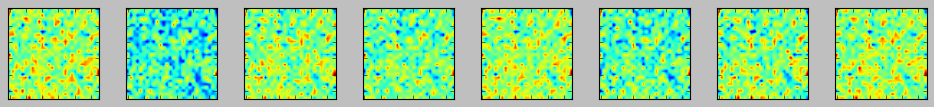

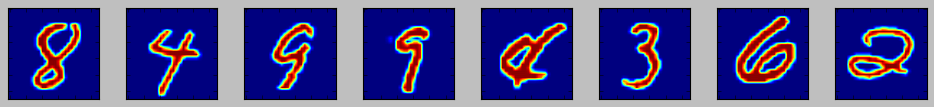

In [37]:
plot_sample_images(sample_G, 8)
plot_sample_images(sample_Data, 8)

In [38]:
d_criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.SGD(D.parameters(), lr=0.001, momentum=0.9)

g_criterion = nn.BCELoss().cuda()
g_optimizer = torch.optim.SGD(G.parameters(), lr=0.001, momentum=0.9)

In [39]:
def optimize_D(steps, bs):
    for _ in range(steps):
        D.zero_grad()

        real_x = sample_Data(bs)
        real_logits = D(real_x)
        real_loss = d_criterion(real_logits, V(torch.ones(bs, 1)).cuda())
        real_loss.backward()
        
        fake_x = sample_G(bs).detach().cuda()
        fake_logits = D(fake_x)
        fake_loss = d_criterion(fake_logits, V(torch.zeros(bs, 1)).cuda())
        fake_loss.backward()
        
        d_optimizer.step()

In [40]:
def optimize_G(steps, bs):
    for _ in range(steps):
        G.zero_grad()

        fake_x = sample_G(bs)
        fake_logits = D(fake_x)
        fake_loss = g_criterion(fake_logits, V(torch.ones(bs, 1)).cuda())
        fake_loss.backward()

        g_optimizer.step()

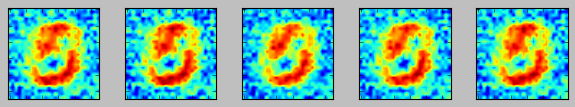

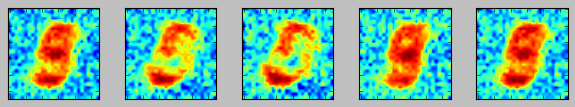

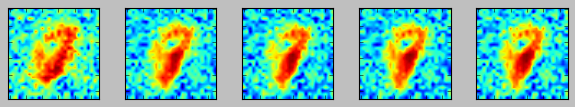

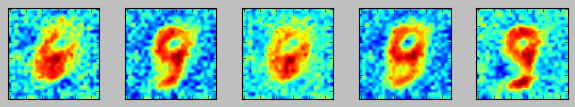

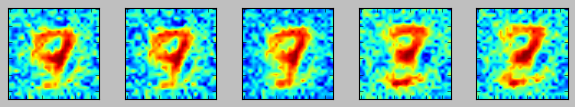

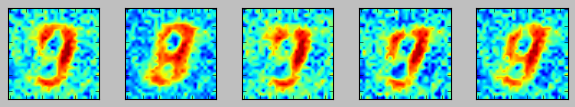

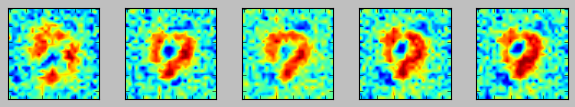

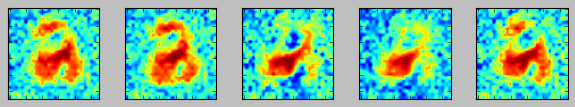

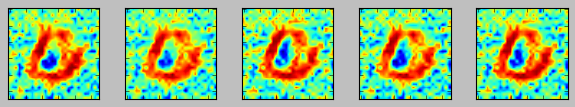

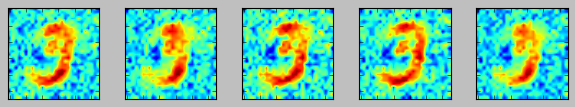

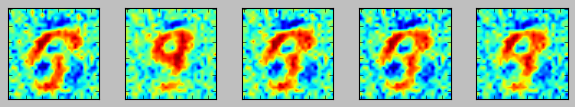

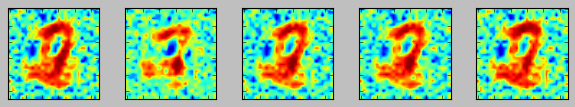

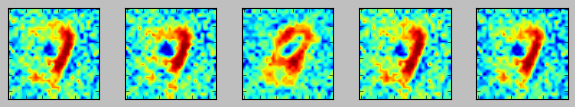

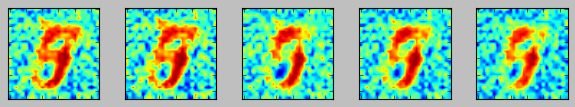

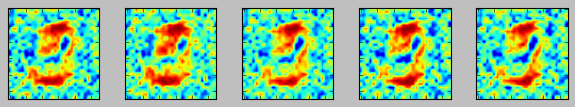

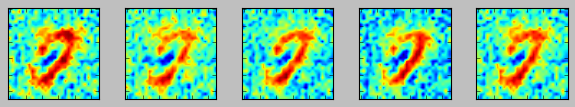

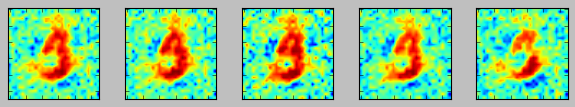

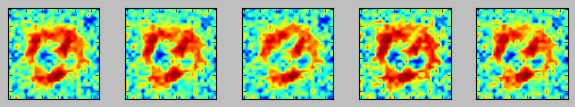

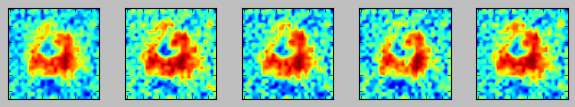

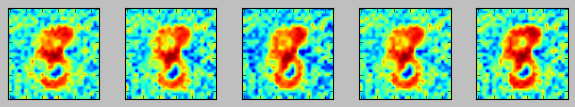

In [83]:
noise = torch.rand(1, latent_size).cuda()
learned_mapping = []

for i in tqdm(range(4000)):
    if i % 10 == 0:
        learned_mapping.append(
            G(noise).reshape(28, -1).cpu().detach().numpy()
        )

    bs = 20
    optimize_D(5, bs)
    optimize_G(5, bs)

    if i % 200 == 0:
        plot_sample_images(sample_G, 5)
        plt.show()

[]

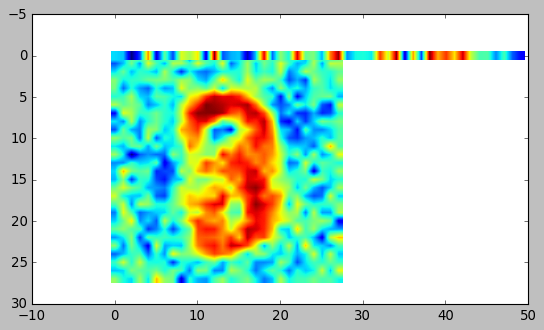

In [92]:
noise = torch.rand(1, latent_size).cuda()

plt.imshow(G(noise).cpu().detach().numpy().reshape(28, -1))
plt.plot()
plt.imshow(noise.cpu())
plt.plot()

In [93]:
class Animator:
    def __init__(self):
        fig, ax = plt.subplots()
        plt.close()
        self.ax = ax
        self.fig = fig
    
    def _loop(self, i):
        return (self.loop(i),)
    
    def animate(self, frames):
        return FuncAnimation(
            self.fig,
            self._loop,
            frames=frames,
            interval=50
        )

In [94]:
class FrameAnimator(Animator):
    def __init__(self, frames):
        super(FrameAnimator, self).__init__()
        self.frames = frames
        print(len(frames))
        
    def loop(self, i):
        if i % 10 == 0:
            print(i)
        return self.ax.imshow(self.frames[i])

    def _animate(self):
        return super(FrameAnimator, self).animate(len(self.frames))

In [96]:
len(learned_mapping)

400

In [97]:
from array2gif import write_gif

In [136]:
np_learned_mapping = np.array(learned_mapping)
np_learned_mapping = np.stack([np_learned_mapping, np_learned_mapping, np_learned_mapping], axis=1)
np_learned_mapping = (np.abs(np_learned_mapping) * 255).astype(int)
np_learned_mapping = [np.array(i) for i in np_learned_mapping.tolist()]

In [146]:
write_gif(np_learned_mapping, 'learned_mapping.gif', fps=1)

<img src="learned_mapping.gif?e2" alt="drawing" width="300"/>

In [82]:
FrameAnimator(learned_mapping[:50])._animate()

50
0
0
10
20
30
40
